In [14]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification


In [15]:
# carrega o dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/jblancoperez/fiap-desafio/main/solicitacoescredito.csv')

print(dataset.head())

# periodoDemonstrativoEmMeses -> converte valores nulos ou 0 em 1
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(np.nan, 1)
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(0, 1)

# faturamentoBruto -> converte valores nulos em 0 
dataset['faturamentoBruto'] = dataset['faturamentoBruto'].replace(np.nan, 0)
#dataset['faturamentoBruto'] = dataset['faturamentoBruto'] / dataset['periodoDemonstrativoEmMeses']
dataset['percentualProtestos'] = dataset['percentualProtestos'].replace(np.nan, 0)

   numero_solicitacao             razaoSocial        nomeFantasia  \
0                   1  James Richardson-Patel  Alexandra Williams   
1                   2      Dr. Geoffrey Walsh   Mr. Darren Arnold   
2                   3           Joanna Hudson      Dr. David Rees   
3                   4    Gordon Jones-Hopkins    Sara Reid-Robson   
4                   5               Nigel Lee  Dr. Stanley Duncan   

         cnpjSemTraco  maiorAtraso  margemBrutaAcumulada  percentualProtestos  \
0  KEBE17609492220843            0              0.252448                  0.0   
1  JRBK88908250677300            0              0.000000                  NaN   
2  GCVQ28531614261293            4              0.624777                  0.0   
3  KJND32266018316396           20              0.000000                  NaN   
4  CGQN15826802440348           20              0.454088                  0.0   

        primeiraCompra  prazoMedioRecebimentoVendas  titulosEmAberto  ...  \
0  2015-12-10T00:00:0

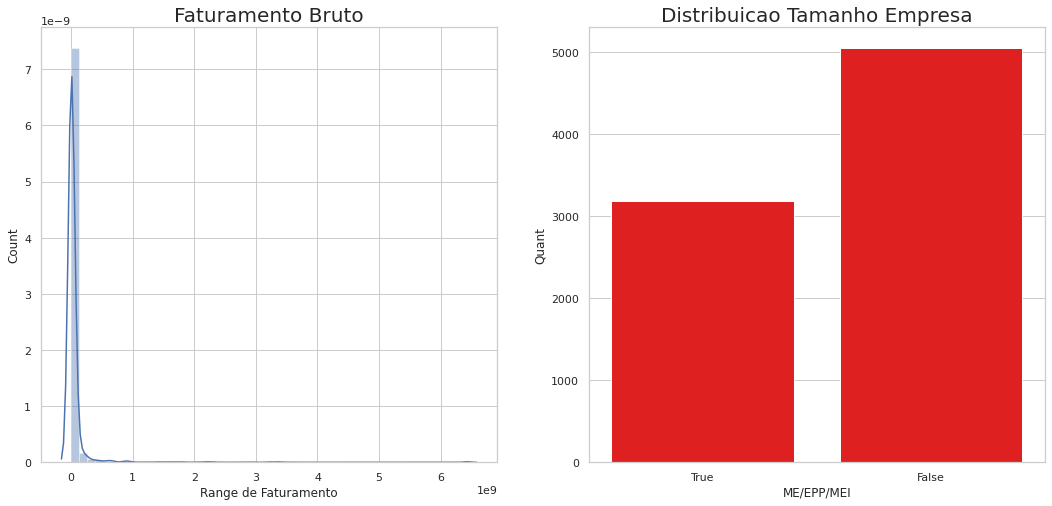

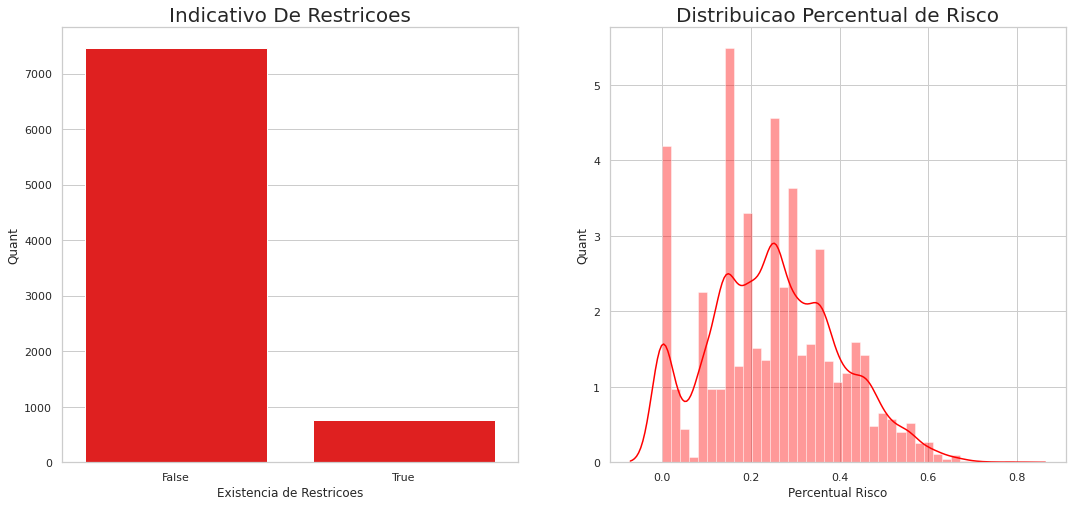

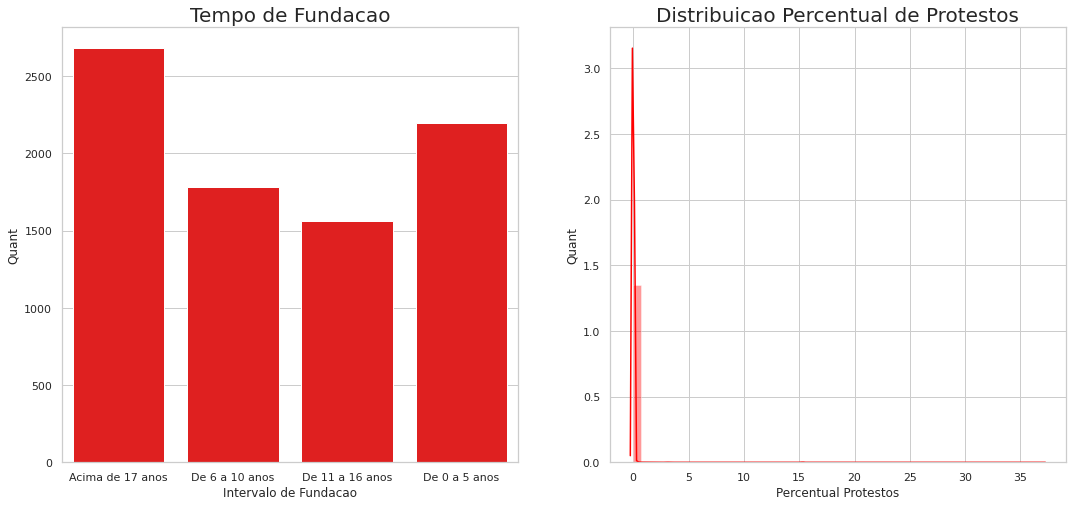

In [16]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(dataset['faturamentoBruto'])
plt.title('Faturamento Bruto', fontsize = 20)
plt.xlabel('Range de Faturamento')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.countplot(dataset['empresa_MeEppMei'], color = 'red')
plt.title('Distribuicao Tamanho Empresa', fontsize = 20)
plt.xlabel('ME/EPP/MEI')
plt.ylabel('Quant')
plt.show()

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.countplot(dataset['restricoes'], color = 'red')
plt.title('Indicativo De Restricoes', fontsize = 20)
plt.xlabel('Existencia de Restricoes')
plt.ylabel('Quant')

plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(dataset['percentualRisco'], color = 'red')
plt.title('Distribuicao Percentual de Risco', fontsize = 20)
plt.xlabel('Percentual Risco')
plt.ylabel('Quant')
plt.show()

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.countplot(dataset['intervaloFundacao'], color = 'red')
plt.title('Tempo de Fundacao', fontsize = 20)
plt.xlabel('Intervalo de Fundacao')
plt.ylabel('Quant')

plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(dataset['percentualProtestos'], color = 'red')
plt.title('Distribuicao Percentual de Protestos', fontsize = 20)
plt.xlabel('Percentual Protestos')
plt.ylabel('Quant')
plt.show()

In [18]:
faturamento_dist = dataset['faturamentoBruto'].values
faturamento_logdist = np.log(dataset['faturamentoBruto'])
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


trace0 = go.Histogram(
    x=faturamento_dist,
    histnorm='probability',
    name="Distribuicao do Faturamento",
    marker = dict(
        color = '#FA5858',
    )
)
trace1 = go.Histogram(
    x=faturamento_logdist,
    histnorm='probability',
    name="Distribuicao do Faturamento em Log",
    marker = dict(
        color = '#58FA82',
    )
)

fig = tools.make_subplots(rows=2, cols=1,
                          subplot_titles=('Distribuicao do Faturamento','Distribuicao do Faturamento - LOG'),
                         print_grid=False)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)


fig['layout'].update(showlegend=True, title='Distribuicao do Faturamento', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [46]:
dataset['faturamentoBruto'].describe()
logcharge.describe()

count    8973.000000
mean            -inf
std              NaN
min             -inf
25%        13.553995
50%        14.929986
75%        16.384016
max        22.583636
Name: faturamentoBruto, dtype: float64

In [47]:
# numero_solicitacao                                                    # irrelevante
# razaoSocial                                                           # irrelevante
# nomeFantasia                                                          # irrelevante
# cnpjSemTraco                                                          # irrelevante
# maiorAtraso                                                           # informação não existe na primeira compra
# margemBrutaAcumulada                                                  # informação não existe na primeira compra
# percentualProtestos = dataset['percentualProtestos']                  # ######## ver tratamento (abaixo)
# primeiraCompra                                                        # informação não existe na primeira compra
# prazoMedioRecebimentoVendas                                           # informação não existe na primeira compra
# titulosEmAberto = dataset['titulosEmAberto']                          # ok
# valorSolicitado                                                       # irrelevante
# status                                                                # informação não existe na primeira compra
definicaoRisco = dataset['definicaoRisco']                            # ######## ver tratamento (abaixo)
# diferencaPercentualRisco                                              # irrelevante
percentualRisco = dataset['percentualRisco']                          # ok
# dashboardCorrelacao                                                   # irrelevante
# valorAprovado                                                         # informação não existe na primeira compra
# dataAprovadoEmComite                                                  # informação não existe na primeira compra (e 8415 linhas com valor nulo)
# periodoBalanco                                                        # 4240 linhas com valor nulo
# ativoCirculante                                                       # 4240 linhas com valor nulo
# passivoCirculante                                                     # 4240 linhas com valor nulo
# totalAtivo                                                            # 4240 linhas com valor nulo
# totalPatrimonioLiquido                                                # 4240 linhas com valor nulo
# endividamento                                                         # 4240 linhas com valor nulo
# duplicatasAReceber                                                    # 4240 linhas com valor nulo
# estoque                                                               # 4240 linhas com valor nulo
faturamentoBruto = logcharge
#dataset['faturamentoBruto']                          # ######## ver tratamento (abaixo)
margemBruta = dataset['margemBruta']                                    # ######## ver tratamento (abaixo)
# periodoDemonstrativoEmMeses                                           # usado para normalizar o faturamentoBruto (acima)
# custos                                                                # irrelevante
# anoFundacao                                                           # irrelevante
intervaloFundacao = dataset['intervaloFundacao']                      # ######## ver tratamento (abaixo)
# capitalSocial                                                         # irrelevante
restricoes = dataset['restricoes']                                      # ######## ver tratamento (abaixo)
empresa_MeEppMei = dataset['empresa_MeEppMei']                        # ######## ver tratamento (abaixo)
# scorePontualidade                                                     # informação não existe na primeira compra
# limiteEmpresaAnaliseCredito = dataset['limiteEmpresaAnaliseCredito']  # ######## ver tratamento (abaixo)
# dataAprovadoNivelAnalista                                             # informação não existe na primeira compra

In [48]:
# monta o dataset que será trabalhado
dataset = pd.concat([
    faturamentoBruto,
    margemBruta,
    restricoes,
    #definicaoRisco,
    #percentualRisco
    intervaloFundacao,
    empresa_MeEppMei
], axis=1)

In [49]:
dataset.head(100)

,faturamentoBruto,margemBruta,restricoes,intervaloFundacao,empresa_MeEppMei
0,14.384726,0.0,False,Acima de 17 anos,True
1,-inf,NaN,NaN,NaN,NaN
2,14.850452,0.0,False,De 6 a 10 anos,True
3,14.066482,0.0,False,De 6 a 10 anos,True
4,17.523696,81459809.0,False,Acima de 17 anos,False
...,...,...,...,...,...
95,12.556067,0.0,False,De 0 a 5 anos,True
96,13.884205,0.0,False,De 0 a 5 anos,True
97,14.759044,424623.0,True,De 11 a 16 anos,True
98,-inf,NaN,NaN,NaN,NaN


In [50]:
# faturamentoBruto -> remove valores nulos ou inferiores a 1.000,00 (outliers?)
dataset['faturamentoBruto'] = dataset['faturamentoBruto'].replace([np.inf, -np.inf], np.nan)
dataset.dropna(subset=['faturamentoBruto'], inplace=True)
#faturamentoBrutoIdx = dataset[(dataset['faturamentoBruto'] < 1000.0)].index
#dataset.drop(faturamentoBrutoIdx, inplace=True)

# margemBruta -> remove valores nulos
dataset.dropna(subset=['margemBruta'], inplace=True)

# intervaloFundacao -> trata como dummy
#intervaloFundacaoDmy = pd.get_dummies(dataset['intervaloFundacao'], drop_first=True)
#dataset.drop(['intervaloFundacao'], axis=1, inplace=True)
#dataset = pd.concat([dataset, intervaloFundacaoDmy], axis=1)
dataset=pd.get_dummies(dataset, columns=["intervaloFundacao"], prefix=["intervaloFundacao"])

# restricoes -> converte valores nulos em falso e transforma bool em int
dataset['restricoes'] = dataset['restricoes'].replace(np.nan, False)
dataset['restricoes'] = dataset['restricoes'].astype(int)

# empresa_MeEppMei -> converte valores nulos em falso e transforma bool em int
dataset['empresa_MeEppMei'] = dataset['empresa_MeEppMei'].replace(np.nan, False)
dataset['empresa_MeEppMei'] = dataset['empresa_MeEppMei'].astype(int)

# limiteEmpresaAnaliseCredito -> remove valores nulos
#dataset.dropna(subset=['limiteEmpresaAnaliseCredito'], inplace=True)

#dataset=pd.get_dummies(dataset, columns=["definicaoRisco"], prefix=["definicaoRisco"])

# remove valores duplicados (cada compra de uma empresa é uma foto)
dataset.drop_duplicates(inplace=True)

# indexa novamente o dataset para remover índices ainda em memória
dataset.reset_index(drop=True, inplace=True)


In [51]:
print(dataset.describe())

       faturamentoBruto   margemBruta   restricoes  empresa_MeEppMei  \
count       4895.000000  4.895000e+03  4895.000000       4895.000000   
mean          15.251255  1.371570e+07     0.096016          0.409806   
std            1.949971  1.037252e+08     0.294644          0.491848   
min            0.000000 -6.148721e+08     0.000000          0.000000   
25%           14.051387  0.000000e+00     0.000000          0.000000   
50%           15.034091  0.000000e+00     0.000000          0.000000   
75%           16.363091  2.305798e+06     0.000000          1.000000   
max           22.583636  3.366843e+09     1.000000          1.000000   

       intervaloFundacao_Acima de 17 anos  intervaloFundacao_De 0 a 5 anos  \
count                         4895.000000                      4895.000000   
mean                             0.329724                         0.263330   
std                              0.470161                         0.440485   
min                              0.0000

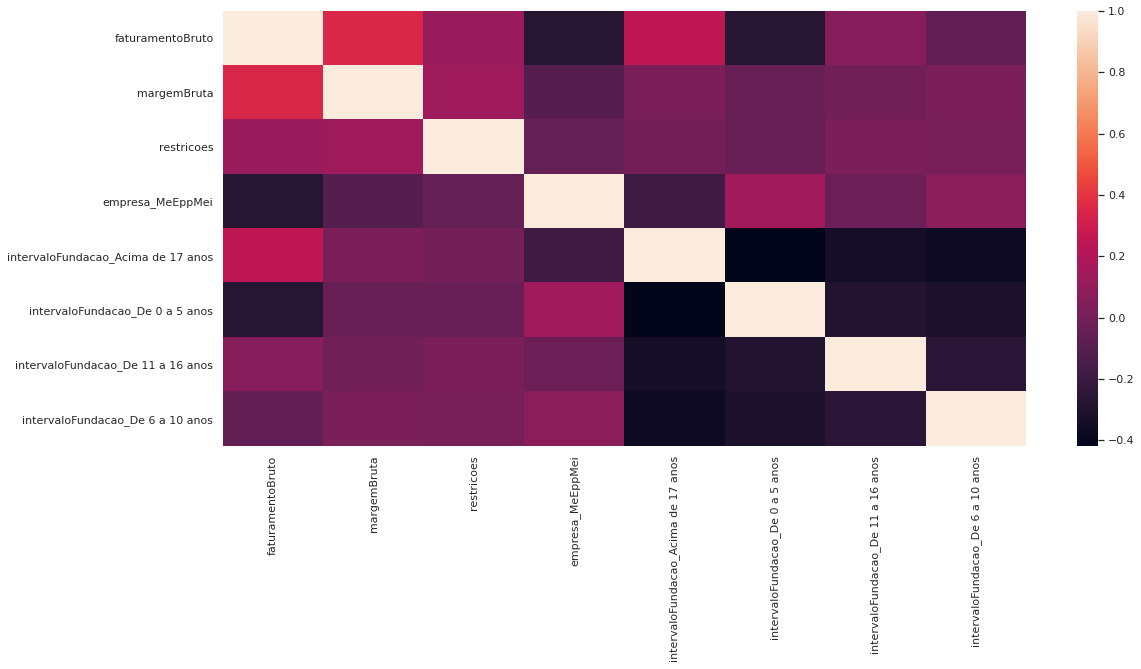

<Figure size 708.661x425.197 with 0 Axes>

In [52]:
import seaborn as sns
sns.heatmap(dataset.corr())

def cm_to_inch(value):
    return value/2.54
 

 
plt.figure(figsize=(cm_to_inch(25), cm_to_inch(15)))

plt.show()

In [53]:
# normaliza os dados utilizando StandardScaler / MinMaxScaler

def normalizaDataset():
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    return(scaler.fit_transform(dataset))

In [54]:
dataset_norm = normalizaDataset()

def printScatter():
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        plt.scatter(pca[row_ix, 0], pca[row_ix, 1])
    # show the plot
    plt.show()

In [55]:
# busca o melhor valor de k para a clusterização, executando para k entre 2 e 20
inertias = []
scores = []
min_max_clusters = range(2, 20)
for i in tqdm(min_max_clusters):
    kmeans = KMeans(n_clusters=i, max_iter=100).fit(dataset_norm)
    inertias.append(kmeans.inertia_)
    scores.append(silhouette_score(dataset.values, kmeans.labels_))

100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


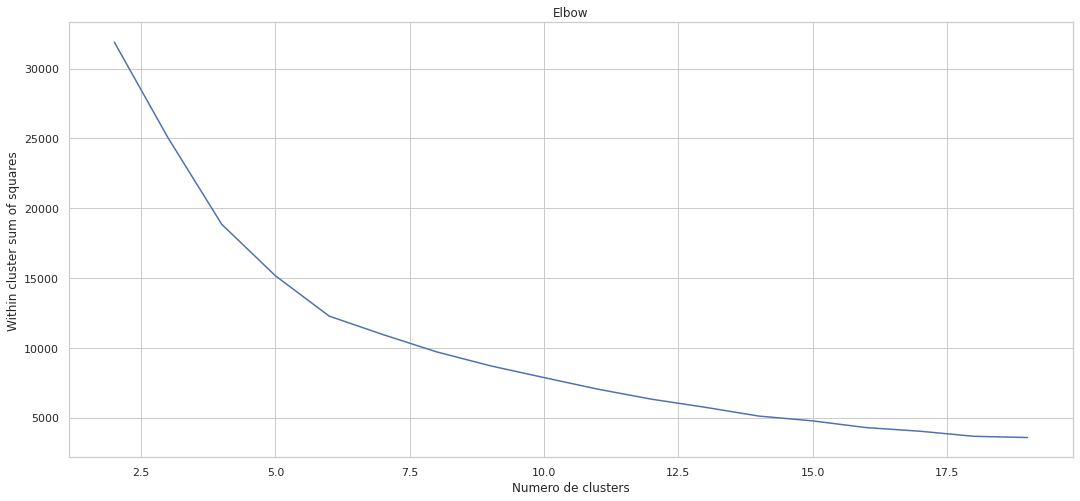

In [56]:
# mostra Elbow
plt.figure(1)
plt.plot(min_max_clusters, inertias)
plt.title('Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Within cluster sum of squares')
plt.show()


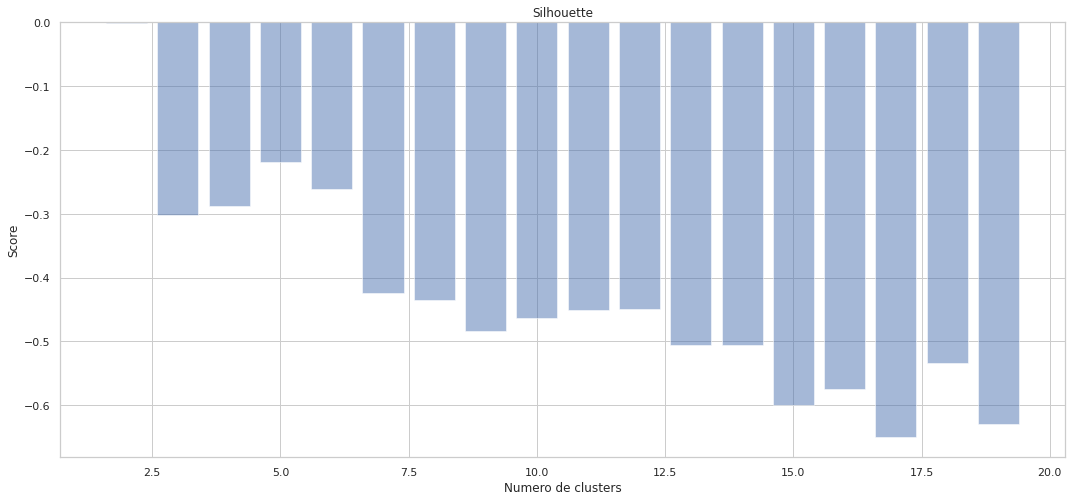

In [57]:
# mostra Silhouette
plt.figure(2)
plt.bar(min_max_clusters, scores, align='center', alpha=0.5)
plt.title('Silhouette')
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
plt.show()


In [58]:
# executa kmeans com o melhor valor de k (encontrado acima)
bestKmeans = KMeans(n_clusters=7, max_iter=1000).fit(dataset_norm)
labels = bestKmeans.labels_
yhat = bestKmeans.predict(dataset_norm)
clusters = unique(yhat)

# gera o dataset completo (adiciona a coluna 'cluster')
saida = pd.concat([dataset, pd.DataFrame({'cluster': labels})], axis=1)

print(saida.head())

   faturamentoBruto  margemBruta  restricoes  empresa_MeEppMei  \
0         14.384726          0.0           0                 1   
1         14.850452          0.0           0                 1   
2         14.066482          0.0           0                 1   
3         17.523696   81459809.0           0                 0   
4         13.730471          0.0           0                 1   

   intervaloFundacao_Acima de 17 anos  intervaloFundacao_De 0 a 5 anos  \
0                                   1                                0   
1                                   0                                0   
2                                   0                                0   
3                                   1                                0   
4                                   0                                0   

   intervaloFundacao_De 11 a 16 anos  intervaloFundacao_De 6 a 10 anos  \
0                                  0                                 0   
1         

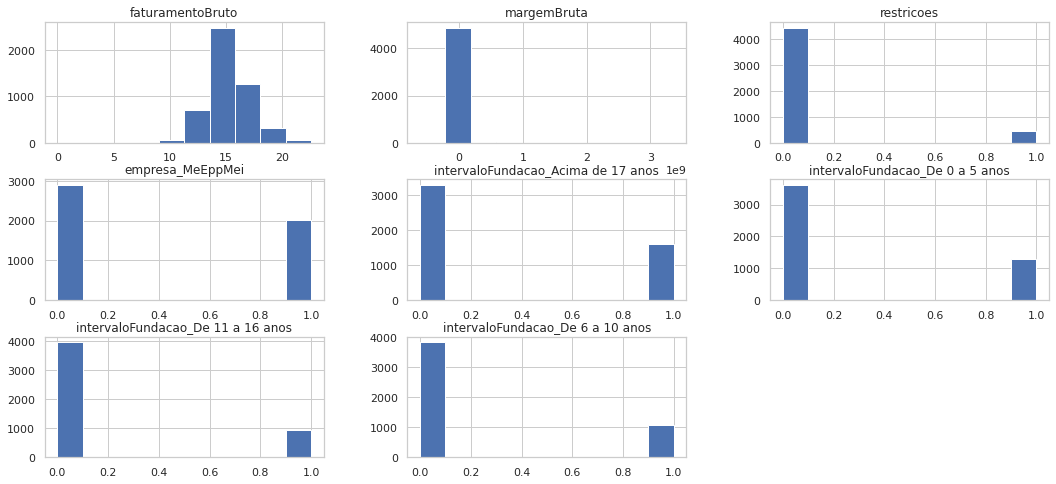

In [59]:
datasetx = DataFrame(dataset)
datasetx.hist()
plt.show()

In [60]:
# salva os dados clusterizados em csv
saida.to_csv(path_or_buf='./clusters.csv', sep=';', decimal=',')

In [61]:
saida.groupby(['restricoes','empresa_MeEppMei','cluster']).count()

faturamentoBruto  margemBruta  \
restricoes empresa_MeEppMei cluster                                  
0          0                1                     542          542   
                            3                     484          484   
                            4                     507          507   
                            5                      13           13   
                            6                    1028         1028   
           1                0                     421          421   
                            1                     646          646   
                            3                     465          465   
                            4                     319          319   
1          0                2                     299          299   
                            5                      16           16   
           1                2                     155          155   

                                     intervaloFundacao_Acima de 17 anos  \
restricoes empresa_MeEppMei cluster                                       
0          0                1                                       542   
                            3                                       484   
                            4                                       507   
                            5                                        13   
                            6                                      1028   
           1                0                                       421   
                            1                                       646   
                            3                                       465   
                            4                                       319   
1          0                2                                       299   
                            5                                        16   
           1                2                                       155   

                                     intervaloFundacao_De 0 a 5 anos  \
restricoes empresa_MeEppMei cluster                                    
0          0                1                                    542   
                            3                                    484   
                            4                                    507   
                            5                                     13   
                            6                                   1028   
           1                0                                    421   
                            1                                    646   
                            3                                    465   
                            4                                    319   
1          0                2                                    299   
                            5                                     16   
           1                2                                    155   

                                     intervaloFundacao_De 11 a 16 anos  \
restricoes empresa_MeEppMei cluster                                      
0          0                1                                      542   
                            3                                      484   
                            4                                      507   
                            5                                       13   
                            6                                     1028   
           1                0                                      421   
                            1                                      646   
                            3                                      465   
                            4                                      319   
1          0                2                                      299   
                            5                                       16   
           1                2     

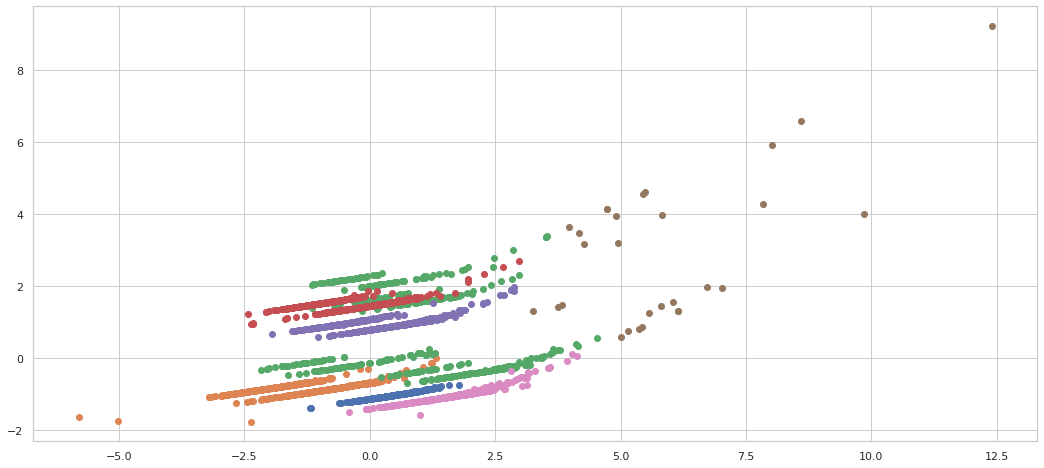

In [62]:
# aplica redução de dimensionalidade para 2 dimensões (plot 2D)
pca = PCA(n_components=2).fit_transform(dataset_norm)

printScatter()

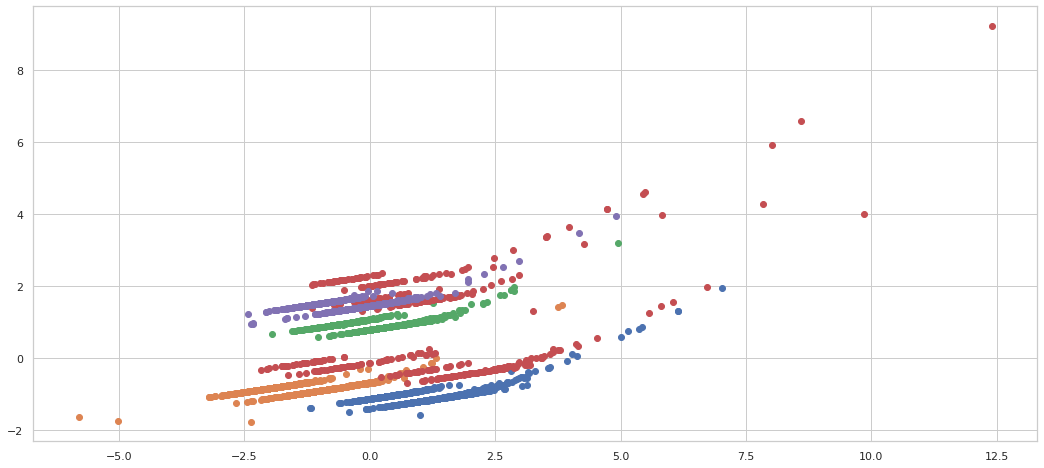

In [63]:
# mini-batch k-means clustering
from sklearn.cluster import MiniBatchKMeans
# define dataset
dataset_norm = normalizaDataset()
# define the model
model = MiniBatchKMeans(n_clusters=5)
# fit the model
model.fit(dataset_norm)
# assign a cluster to each example
yhat = model.predict(dataset_norm)
# retrieve unique clusters
clusters = unique(yhat)
pca = PCA(n_components=2).fit_transform(dataset_norm)
#Imprime
printScatter()

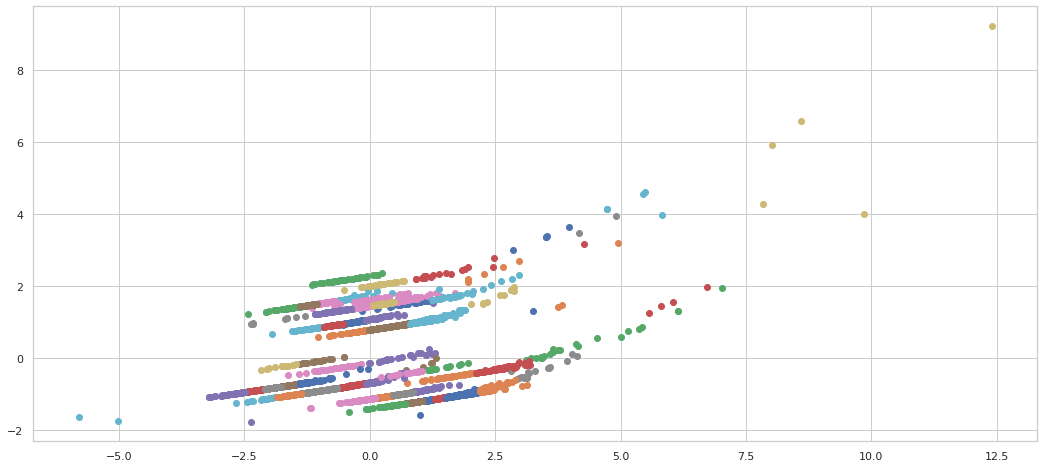

In [64]:
# affinity propagation clustering
from sklearn.cluster import AffinityPropagation
# define dataset
dataset_norm = normalizaDataset()
# define the model
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(dataset_norm)
# assign a cluster to each example
yhat = model.predict(dataset_norm)
# retrieve unique clusters
clusters = unique(yhat)
pca = PCA(n_components=2).fit_transform(dataset_norm)
#Imprime
printScatter()

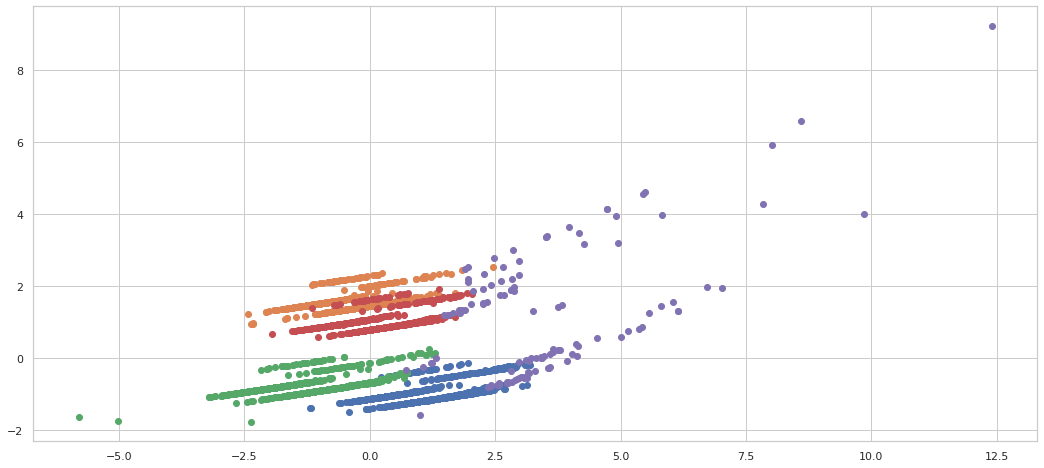

In [65]:
# gaussian mixture clustering
from sklearn.mixture import GaussianMixture
# define dataset
dataset_norm = normalizaDataset()
# define the model
model = GaussianMixture(n_components=5)
# fit the model
model.fit(dataset_norm)
# assign a cluster to each example
yhat = model.predict(dataset_norm)
# retrieve unique clusters
clusters = unique(yhat)
pca = PCA(n_components=2).fit_transform(dataset_norm)
#Imprime
printScatter()